d:\Hacktober\Noob-to-Ninja-ML\Image RAG for Dataset&Pdfs\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating val split: 100%|██████████| 1158/1158 [00:00<00:00, 1994.10 examples/s]


Images saved to ./images_data
Images added to the database.
ID: 1
Distance: 1.466855525970459
Path: ./images_data\image2.png


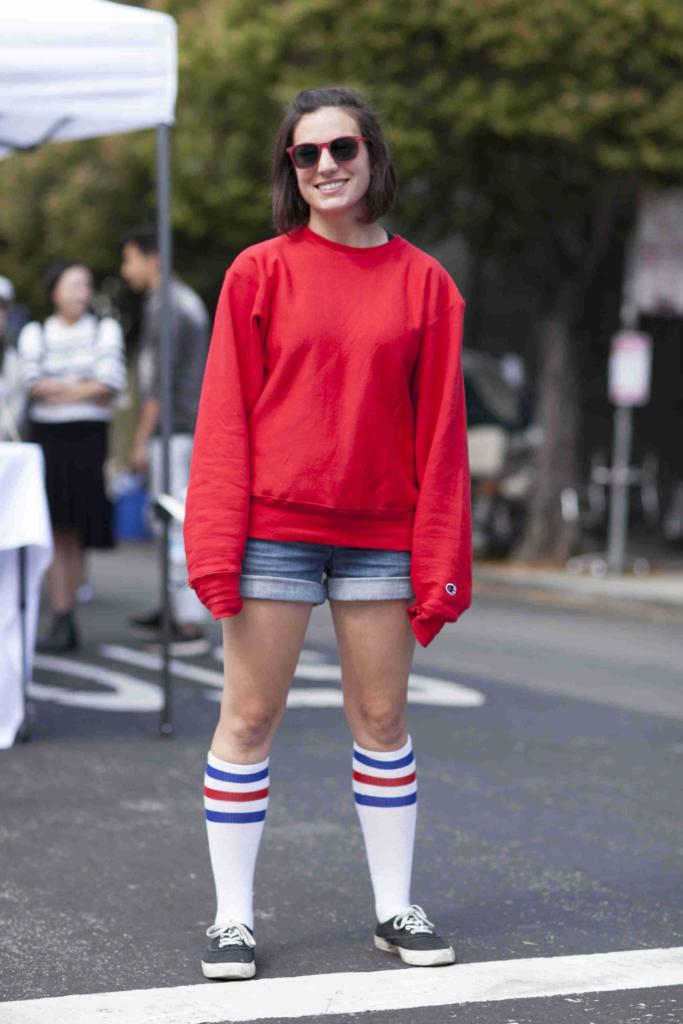

In [2]:
import os
import chromadb
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
from chromadb.utils.data_loaders import ImageLoader
from datasets import load_dataset
from IPython.display import Image, display

# Set up directories
cache_dir = "./dataset_cache"
dataset_folder = './images_data'
chroma_db_path = "./image_vdb"
os.makedirs(cache_dir, exist_ok=True)
os.makedirs(dataset_folder, exist_ok=True)

# Load a smaller subset of the dataset
dataset = load_dataset("detection-datasets/fashionpedia", split="train[:100]", cache_dir=cache_dir)

def save_images(dataset, dataset_folder):
    """Saves images from the dataset into the specified folder."""
    for i, example in enumerate(dataset):
        image_path = os.path.join(dataset_folder, f'image{i+1}.png')
        if not os.path.exists(image_path):
            example['image'].save(image_path)
    print(f"Images saved to {dataset_folder}")

# Save images
save_images(dataset, dataset_folder)

# Set up ChromaDB
chroma_client = chromadb.PersistentClient(path=chroma_db_path)
image_loader = ImageLoader()
CLIP = OpenCLIPEmbeddingFunction()
image_vdb = chroma_client.get_or_create_collection(name="image", embedding_function=CLIP, data_loader=image_loader)

# Add images to the vector database
ids = [str(i) for i in range(len(dataset))]
uris = [os.path.join(dataset_folder, f'image{i+1}.png') for i in range(len(dataset))]
image_vdb.add(ids=ids, uris=uris)
print("Images added to the database.")

def query_db(query, results=1):
    """Queries the image vector database using text and returns image results."""
    return image_vdb.query(query_texts=[query], n_results=results, include=['uris', 'distances'])

def print_results(results):
    """Displays images and their distances based on the query."""
    for idx, uri in enumerate(results['uris'][0]):
        print(f"ID: {results['ids'][0][idx]}")
        print(f"Distance: {results['distances'][0][idx]}")
        print(f"Path: {uri}")
        display(Image(filename=uri, width=300))
        print("\n")

# Example usage
query = 'red tops'
results = query_db(query)
print_results(results)